In [ ]:
!unzip -q TestDataSet.zip -d ./TestDataSet

 ## TASK 1

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
import os
import json

# --- Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load pretrained ResNet-34 ---
resnet34 = torchvision.models.resnet34(weights='IMAGENET1K_V1')
resnet34.eval().to(device)

# --- Normalization ---
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# --- Dataset path ---
dataset_path = "/content/drive/MyDrive/TestDataSet"

# --- Load the labels_list.json as ordered list of "index: class name" strings ---
with open(os.path.join(dataset_path, "labels_list.json"), "r") as f:
    label_lines = json.load(f)

# Extract the indices (e.g., "401: accordion" -> 401)
true_imagenet_indices = [int(line.split(":")[0]) for line in label_lines]

# --- Load dataset using ImageFolder ---
imagefolder = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)

# --- Map folder index to correct ImageNet class index ---
folder_to_imagenet_index = {
    class_name: true_imagenet_indices[i]
    for i, class_name in enumerate(imagefolder.classes)
}

# --- Replace labels in dataset.samples ---
new_samples = []
for path, folder_idx in imagefolder.samples:
    folder_name = os.path.basename(os.path.dirname(path))  # e.g. 'n03014705'
    imagenet_label = folder_to_imagenet_index[folder_name]
    new_samples.append((path, imagenet_label))

# Update dataset
imagefolder.samples = new_samples

# --- Dataloader ---
dataloader = DataLoader(imagefolder, batch_size=32, shuffle=False)

# --- Evaluation function ---
def evaluate(model, dataloader):
    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, top1_preds = outputs.topk(1, dim=1)
            _, top5_preds = outputs.topk(5, dim=1)

            top1_correct += (top1_preds.squeeze() == labels).sum().item()
            top5_correct += sum([labels[i] in top5_preds[i] for i in range(labels.size(0))])
            total += labels.size(0)

    top1 = 100 * top1_correct / total


    top5 = 100 * top5_correct / total
    return top1, top5

# --- Run and print results ---
top1_acc, top5_acc = evaluate(resnet34, dataloader)
print(f"\n✅ Final Top-1 Accuracy: {top1_acc:.2f}%")
print(f"✅ Final Top-5 Accuracy: {top5_acc:.2f}%")


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 177MB/s]
Evaluating: 100%|██████████| 16/16 [06:13<00:00, 23.32s/it]


✅ Final Top-1 Accuracy: 76.00%
✅ Final Top-5 Accuracy: 94.20%


In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def plot_top5_for_clean(image_tensor, label, model, idx=None):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)
    label = label.to(device)

    with torch.no_grad():
        output = model(image_tensor)
        probs = F.softmax(output, dim=1)
        top5_prob, top5_classes = torch.topk(probs, 5)

    top5_prob = top5_prob.squeeze().cpu().numpy()
    top5_classes = top5_classes.squeeze().cpu().numpy()

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].imshow(inv_normalize(image_tensor.squeeze(0).cpu()).permute(1, 2, 0).clamp(0, 1))
    axs[0].axis("off")
    axs[0].set_title(f"Original Image {f'#{idx}' if idx is not None else ''}")

    axs[1].barh([str(cls) for cls in top5_classes], top5_prob)
    axs[1].invert_yaxis()
    axs[1].set_xlim([0, 1.0])
    axs[1].set_xlabel("Confidence")
    axs[1].set_title("Top-5 Predictions")

    plt.tight_layout()
    plt.show()

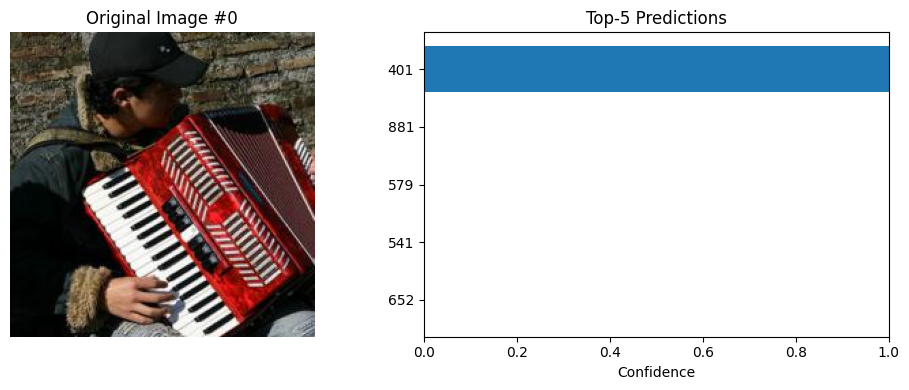

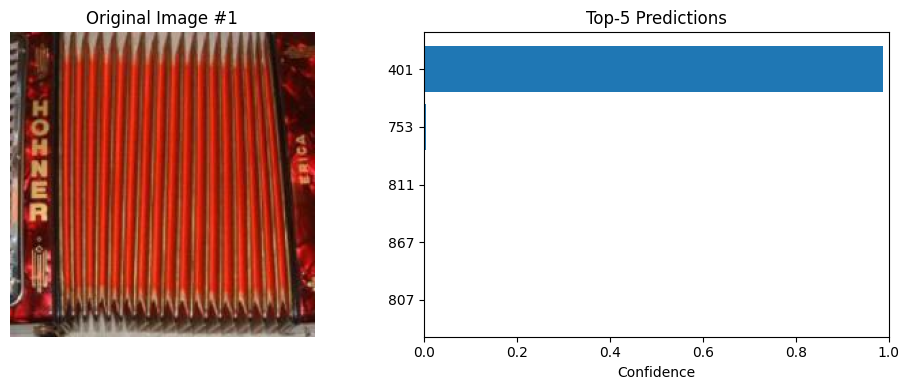

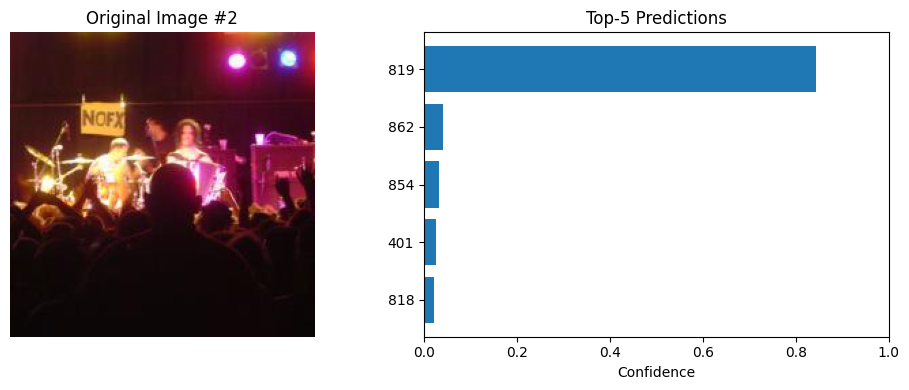

In [ ]:
for idx in range(3):  # adjust to 5 if needed
    img, label = imagefolder[idx]
    plot_top5_for_clean(img, torch.tensor(label), resnet34, idx=idx)

 ## TASK 2

Generating FGSM: 100%|██████████| 500/500 [00:25<00:00, 19.77it/s]



🔍 Visualizing changed predictions:


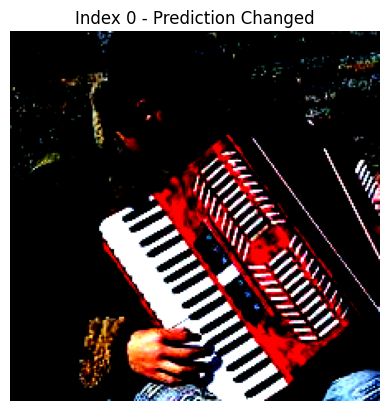

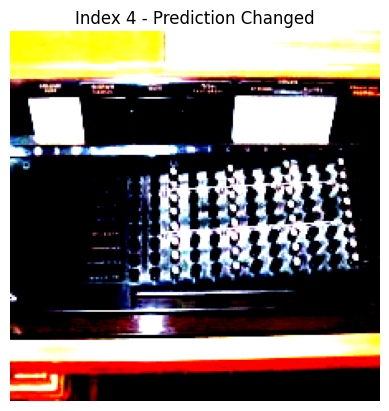

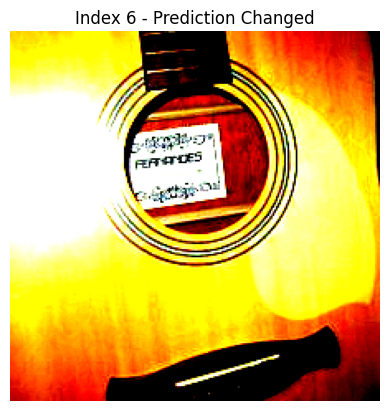

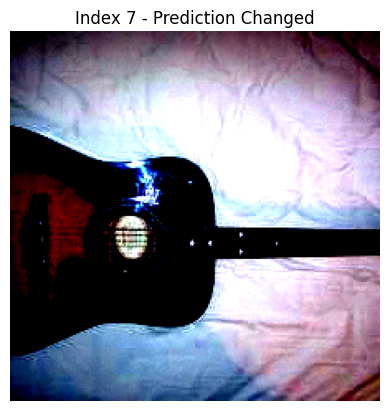

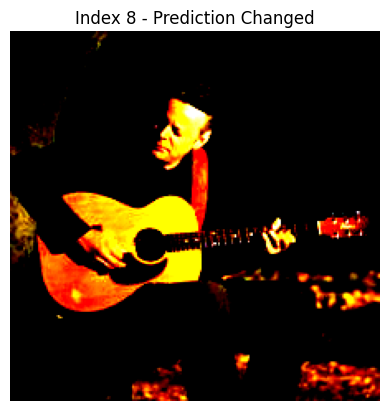


⚠️ Adversarial Top-1 Accuracy: 26.40%
⚠️ Adversarial Top-5 Accuracy: 50.60%


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.02

# Load ResNet-34
resnet34 = torchvision.models.resnet34(weights='IMAGENET1K_V1')
resnet34.eval().to(device)

# ImageNet normalization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(device)

inv_normalize = transforms.Normalize(
    mean=(-mean / std).squeeze().tolist(),
    std=(1.0 / std).squeeze().tolist()
)

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.squeeze().tolist(), std=std.squeeze().tolist())
])

# Load dataset
dataset_path = "/content/drive/MyDrive/TestDataSet"
with open(os.path.join(dataset_path, "labels_list.json"), "r") as f:
    label_lines = json.load(f)
true_imagenet_indices = [int(line.split(":")[0]) for line in label_lines]

imagefolder = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
folder_to_imagenet_index = {
    class_name: true_imagenet_indices[i]
    for i, class_name in enumerate(imagefolder.classes)
}
imagefolder.samples = [
    (path, folder_to_imagenet_index[os.path.basename(os.path.dirname(path))])
    for path, _ in imagefolder.samples
]

dataloader = DataLoader(imagefolder, batch_size=1, shuffle=False)

# Output folder
output_dir = "/content/drive/MyDrive/AdversarialTestSet1"
os.makedirs(output_dir, exist_ok=True)

# FGSM Attack
def fgsm_attack(image, label, epsilon):
    image.requires_grad = True
    output = resnet34(image)
    loss = torch.nn.functional.cross_entropy(output, label)
    resnet34.zero_grad()
    loss.backward()
    grad_sign = image.grad.data.sign()
    adv_image = image + epsilon * grad_sign
    adv_image = torch.clamp(adv_image, 0, 1)
    return adv_image.detach()

# Save adversarial images
adv_images = []
true_labels = []
pred_changed = []

for idx, (img, label) in enumerate(tqdm(dataloader, desc="Generating FGSM")):
    img, label = img.to(device), label.to(device)

    # Save original prediction
    with torch.no_grad():
        original_pred = resnet34(img).argmax(dim=1).item()

    # Create adversarial image
    adv_img = fgsm_attack(img.clone(), label, epsilon)

    # Get adversarial prediction
    with torch.no_grad():
        adv_pred = resnet34(adv_img).argmax(dim=1).item()

    # Save if needed
    adv_images.append(adv_img.squeeze().cpu())
    true_labels.append(label.item())
    pred_changed.append(original_pred != adv_pred)

    # Save to disk
    filename = f"{idx:04d}.png"
    unnormalized_img = inv_normalize(adv_img.squeeze().cpu()).clamp(0, 1)
    torchvision.utils.save_image(unnormalized_img, os.path.join(output_dir, filename))

# Visualization of 3–5 changed predictions
print("\n🔍 Visualizing changed predictions:")
count = 0
for i in range(len(adv_images)):
    if pred_changed[i]:
        plt.imshow(np.transpose(adv_images[i].numpy(), (1, 2, 0)))
        plt.title(f"Index {i} - Prediction Changed")
        plt.axis("off")
        plt.show()
        count += 1
    if count == 5:
        break

# Evaluate accuracy on adversarial images
class AdvDataset(torch.utils.data.Dataset):
    def __init__(self, image_tensors, labels):
        self.images = image_tensors
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

adv_dataset = AdvDataset(adv_images, true_labels)
adv_loader = DataLoader(adv_dataset, batch_size=32)

def evaluate(model, dataloader):
    top1_correct = 0
    top5_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, top1 = outputs.topk(1, dim=1)
            _, top5 = outputs.topk(5, dim=1)
            top1_correct += (top1.squeeze() == labels).sum().item()
            top5_correct += sum([labels[i] in top5[i] for i in range(labels.size(0))])
            total += labels.size(0)
    return 100 * top1_correct / total, 100 * top5_correct / total

# Final report
top1_adv, top5_adv = evaluate(resnet34, adv_loader)
print(f"\n⚠️ Adversarial Top-1 Accuracy: {top1_adv:.2f}%")
print(f"⚠️ Adversarial Top-5 Accuracy: {top5_adv:.2f}%")


In [ ]:
import torch.nn.functional as F

def visualize_fgsm(original_img, adv_img, label, model, idx=None):
    model.eval()
    original_img = original_img.detach().to(device)
    adv_img = adv_img.detach().to(device)
    label = label.detach().to(device)

    with torch.no_grad():
        output = model(adv_img.unsqueeze(0))
        probs = F.softmax(output, dim=1)
        top5_prob, top5_classes = torch.topk(probs, 5)
        top5_prob = top5_prob.squeeze().cpu().numpy()
        top5_classes = top5_classes.squeeze().cpu().numpy()

    noise = adv_img - original_img
    scaled_noise = (noise - noise.min()) / (noise.max() - noise.min() + 1e-8)

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    axs[0].imshow(inv_normalize(original_img.cpu()).permute(1, 2, 0).clamp(0, 1))
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(inv_normalize(adv_img.cpu()).permute(1, 2, 0).clamp(0, 1))
    axs[1].set_title("Adversarial")
    axs[1].axis("off")

    axs[2].imshow(scaled_noise.cpu().permute(1, 2, 0).clamp(0, 1))
    axs[2].set_title("Noise (scaled)")
    axs[2].axis("off")

    axs[3].barh([str(cls) for cls in top5_classes], top5_prob)
    axs[3].invert_yaxis()
    axs[3].set_xlim([0, 1])
    axs[3].set_title("Top-5 Predictions")
    axs[3].set_xlabel("Confidence")

    plt.tight_layout()
    if idx is not None:
        plt.savefig(f"fgsm_sample_{idx}.png", dpi=300)
    plt.show()

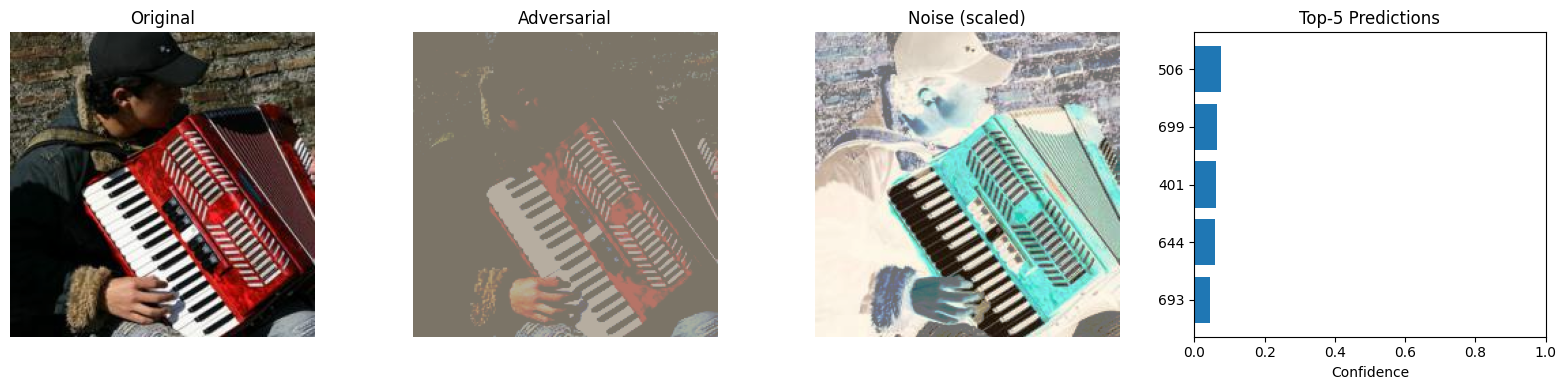

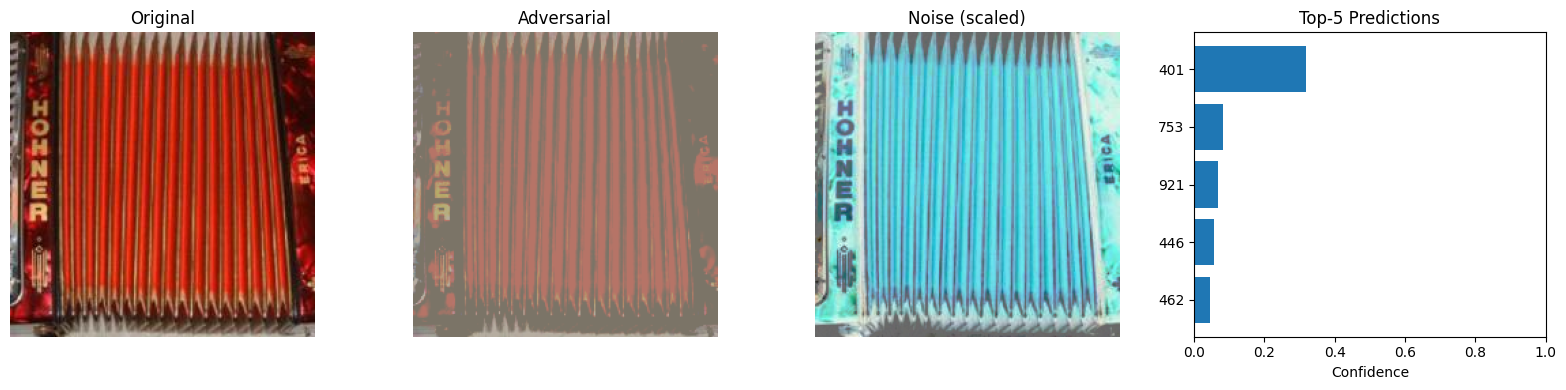

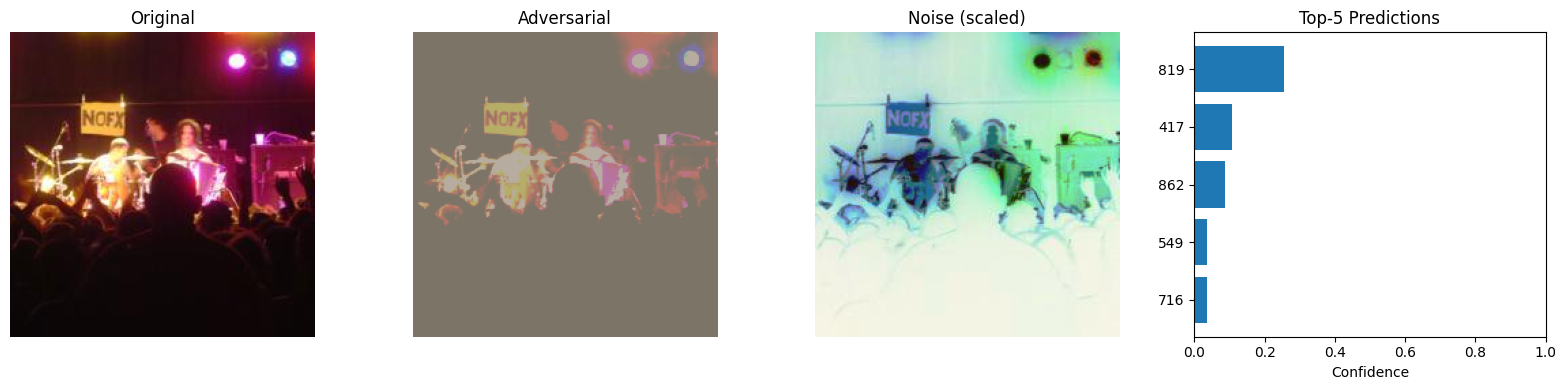

In [ ]:
for idx in range(3):
    img, lbl = imagefolder[idx]
    img = img.to(device)
    lbl_tensor = torch.tensor([lbl]).to(device)

    adv_img = fgsm_attack(img.unsqueeze(0), lbl_tensor, epsilon=0.02)
    visualize_fgsm(img, adv_img.squeeze(), lbl_tensor.squeeze(), resnet34, idx=idx)

 ## TASK 3

PGD Attack: 100%|██████████| 500/500 [00:52<00:00,  9.43it/s]



🔍 PGD Attack Visualizations (Changed Predictions):


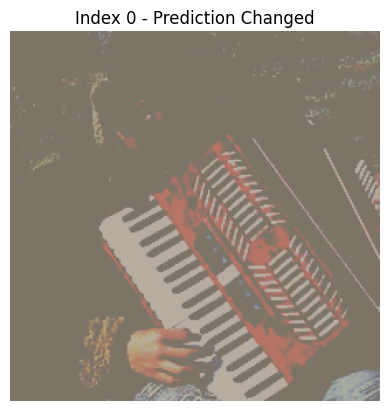

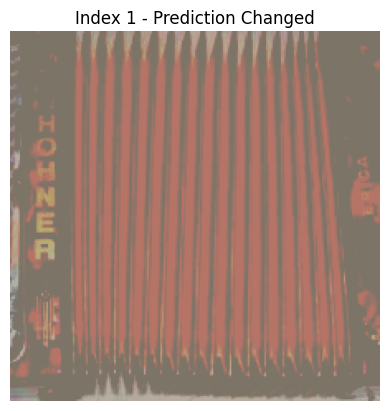

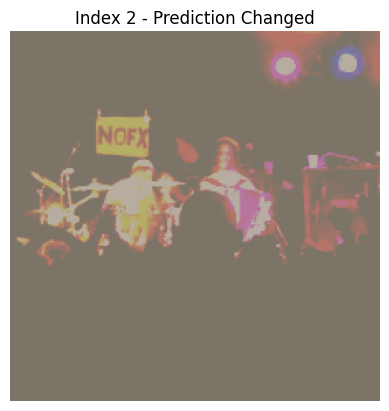

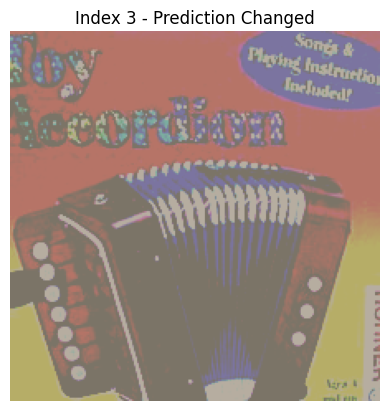

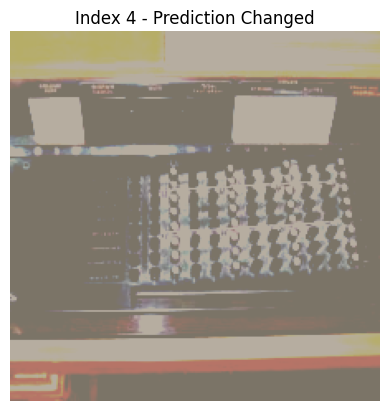


🔥 PGD Adversarial Top-1 Accuracy: 1.00%
🔥 PGD Adversarial Top-5 Accuracy: 10.20%


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import json
from PIL import Image
import matplotlib.pyplot as plt

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.02
alpha = 0.005   # Step size
num_steps = 5   # Number of PGD steps

# Load model
resnet34 = torchvision.models.resnet34(weights='IMAGENET1K_V1')
resnet34.eval().to(device)

# Normalization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(device)

normalize = transforms.Normalize(mean.squeeze().tolist(), std.squeeze().tolist())
inv_normalize = transforms.Normalize(
    mean=(-mean / std).squeeze().tolist(),
    std=(1.0 / std).squeeze().tolist()
)

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# Load dataset and map correct labels
dataset_path = "/content/drive/MyDrive/TestDataSet"
with open(os.path.join(dataset_path, "labels_list.json"), "r") as f:
    label_lines = json.load(f)
true_imagenet_indices = [int(line.split(":")[0]) for line in label_lines]

imagefolder = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
folder_to_imagenet_index = {
    class_name: true_imagenet_indices[i]
    for i, class_name in enumerate(imagefolder.classes)
}
imagefolder.samples = [
    (path, folder_to_imagenet_index[os.path.basename(os.path.dirname(path))])
    for path, _ in imagefolder.samples
]

dataloader = DataLoader(imagefolder, batch_size=1, shuffle=False)

# Output directory
output_dir = "/content/drive/MyDrive/AdversarialTestSet2"
os.makedirs(output_dir, exist_ok=True)

# PGD Attack function
def pgd_attack(image, label, epsilon, alpha, steps):
    orig = image.detach()
    perturbed = image.clone().detach().requires_grad_(True)

    for _ in range(steps):
        output = resnet34(perturbed)
        loss = torch.nn.functional.cross_entropy(output, label)
        resnet34.zero_grad()
        loss.backward()
        grad = perturbed.grad.data.sign()
        perturbed = perturbed + alpha * grad
        perturbed = torch.max(torch.min(perturbed, orig + epsilon), orig - epsilon)
        perturbed = torch.clamp(perturbed, 0, 1).detach().requires_grad_(True)

    return perturbed.detach()

# Adversarial image generation
adv_images = []
true_labels = []
pred_changed = []

for idx, (img, label) in enumerate(tqdm(dataloader, desc="PGD Attack")):
    img, label = img.to(device), label.to(device)
    with torch.no_grad():
        orig_pred = resnet34(img).argmax(dim=1).item()

    adv_img = pgd_attack(img.clone(), label, epsilon, alpha, num_steps)
    with torch.no_grad():
        adv_pred = resnet34(adv_img).argmax(dim=1).item()

    # Save adversarial image
    adv_images.append(adv_img.squeeze().cpu())
    true_labels.append(label.item())
    pred_changed.append(orig_pred != adv_pred)

    # Save to disk
    out_path = os.path.join(output_dir, f"{idx:04d}.png")
    torchvision.utils.save_image(inv_normalize(adv_img.squeeze().cpu()).clamp(0, 1), out_path)

# Visualization (3–5 changed predictions)
print("\n🔍 PGD Attack Visualizations (Changed Predictions):")
count = 0
for i in range(len(adv_images)):
    if pred_changed[i]:
        plt.imshow(inv_normalize(adv_images[i]).permute(1, 2, 0).clamp(0, 1))
        plt.title(f"Index {i} - Prediction Changed")
        plt.axis("off")
        plt.show()
        count += 1
    if count == 5:
        break

# Evaluation
class AdvDataset(torch.utils.data.Dataset):
    def __init__(self, image_tensors, labels):
        self.images = image_tensors
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

adv_dataset = AdvDataset(adv_images, true_labels)
adv_loader = DataLoader(adv_dataset, batch_size=32)

def evaluate(model, dataloader):
    top1_correct = 0
    top5_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, top1 = outputs.topk(1, dim=1)
            _, top5 = outputs.topk(5, dim=1)
            top1_correct += (top1.squeeze() == labels).sum().item()
            top5_correct += sum([labels[i] in top5[i] for i in range(labels.size(0))])
            total += labels.size(0)
    return 100 * top1_correct / total, 100 * top5_correct / total

top1_adv, top5_adv = evaluate(resnet34, adv_loader)
print(f"\n🔥 PGD Adversarial Top-1 Accuracy: {top1_adv:.2f}%")
print(f"🔥 PGD Adversarial Top-5 Accuracy: {top5_adv:.2f}%")


In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_pgd(original_img, adv_img, label, model, idx=None):
    model.eval()
    original_img = original_img.detach().to(device)
    adv_img = adv_img.detach().to(device)
    label = label.detach().to(device)

    with torch.no_grad():
        output = model(adv_img.unsqueeze(0))
        probs = F.softmax(output, dim=1)
        top5_prob, top5_classes = torch.topk(probs, 5)
        top5_prob = top5_prob.squeeze().cpu().numpy()
        top5_classes = top5_classes.squeeze().cpu().numpy()

    noise = adv_img - original_img
    scaled_noise = (noise - noise.min()) / (noise.max() - noise.min() + 1e-8)

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(inv_normalize(original_img.cpu()).permute(1, 2, 0).clamp(0, 1))
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(inv_normalize(adv_img.cpu()).permute(1, 2, 0).clamp(0, 1))
    axs[1].set_title("Adversarial")
    axs[1].axis("off")

    axs[2].imshow(scaled_noise.cpu().permute(1, 2, 0).clamp(0, 1))
    axs[2].set_title("Noise (scaled)")
    axs[2].axis("off")

    axs[3].barh([str(cls) for cls in top5_classes], top5_prob)
    axs[3].invert_yaxis()
    axs[3].set_xlim([0, 1])
    axs[3].set_title("Top-5 Predictions")
    axs[3].set_xlabel("Confidence")

    plt.tight_layout()
    if idx is not None:
        plt.savefig(f"pgd_sample_{idx}.png", dpi=300)
    plt.show()

In [ ]:
# def pgd_attack(image, label, epsilon, alpha, steps):
#     orig = image.detach()
#     perturbed = image.clone().detach().requires_grad_(True)

#     for _ in range(steps):
#         output = resnet34(perturbed)
#         loss = torch.nn.functional.cross_entropy(output, label)
#         resnet34.zero_grad()
#         loss.backward()
#         grad = perturbed.grad.data.sign()
#         perturbed = perturbed + alpha * grad
#         perturbed = torch.max(torch.min(perturbed, orig + epsilon), orig - epsilon)
#         perturbed = torch.clamp(perturbed, 0, 1).detach().requires_grad_(True)

#     return perturbed.detach()

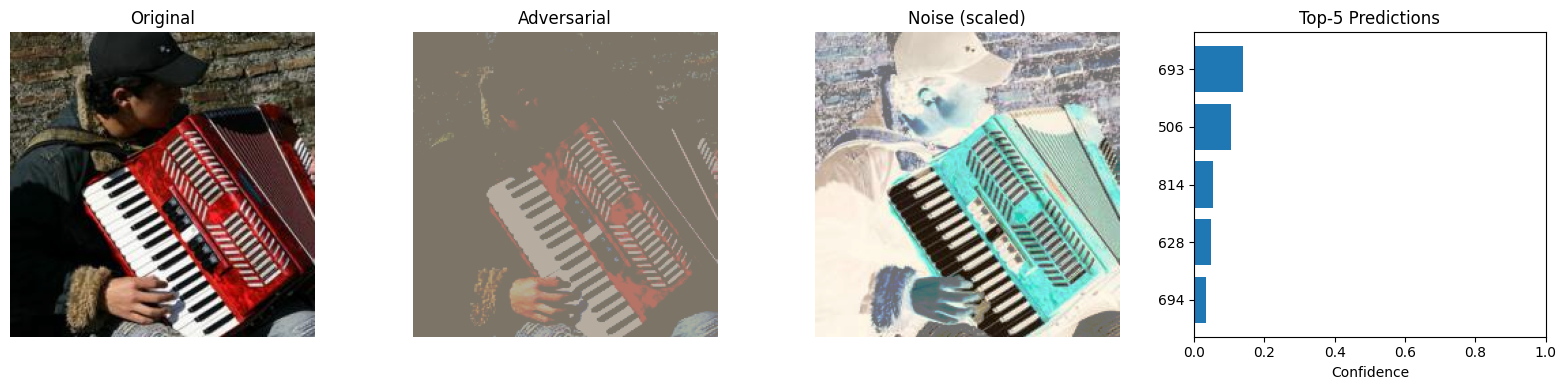

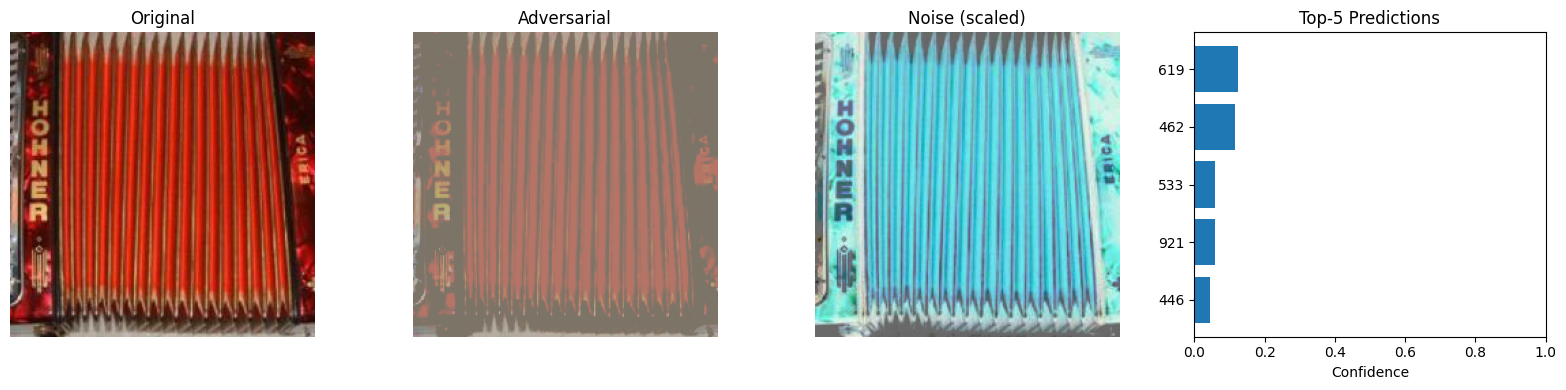

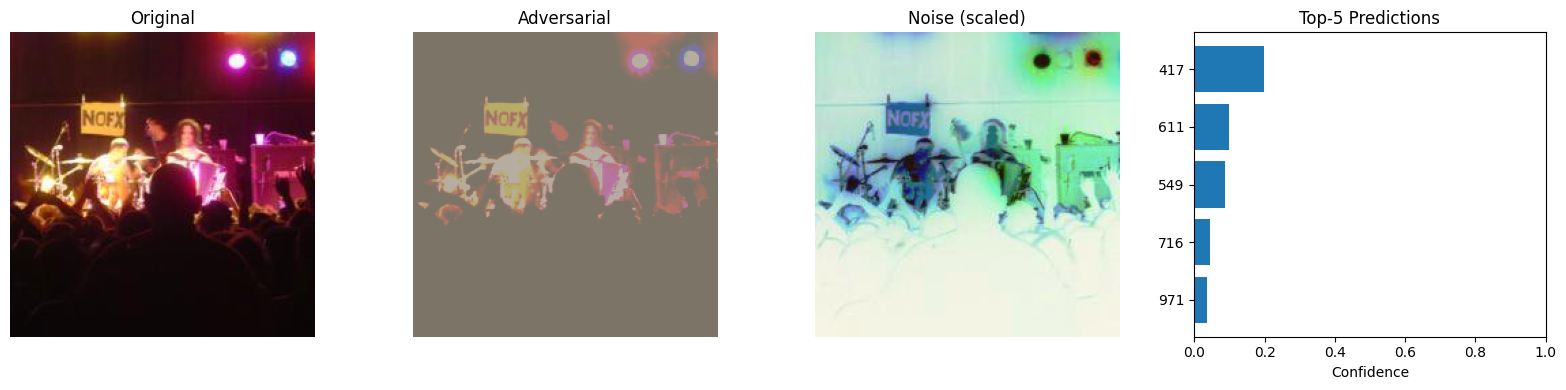

In [ ]:
for idx in range(3):  # or 5
    img, lbl = imagefolder[idx]
    img = img.to(device)
    lbl_tensor = torch.tensor([lbl]).to(device)

    adv_img = pgd_attack(img.unsqueeze(0), lbl_tensor, epsilon=0.02, alpha=0.005, steps=5)
    visualize_pgd(img, adv_img.squeeze(0), lbl_tensor.squeeze(0), resnet34, idx=idx)

 ## TASK 4

In [ ]:
!unzip -q TestDataSet.zip -d ./TestDataSet

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 200MB/s]
Patch Attack: 100%|██████████| 500/500 [11:36<00:00,  1.39s/it]


🎯 Patch Attack Visualizations:


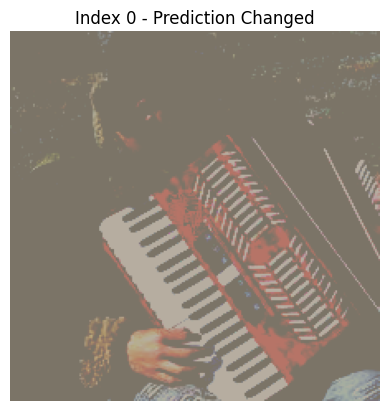

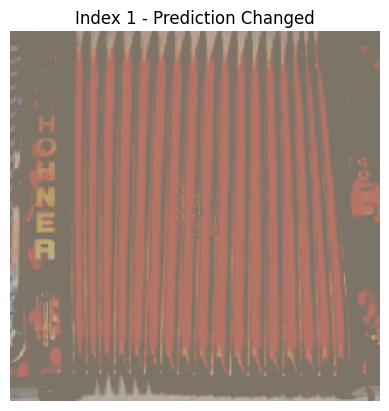

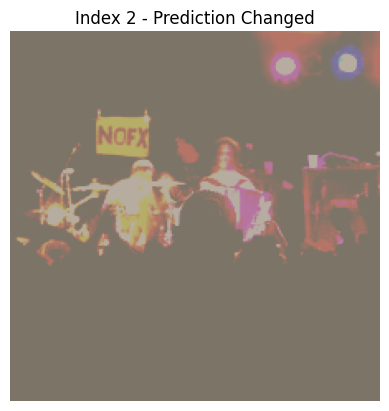

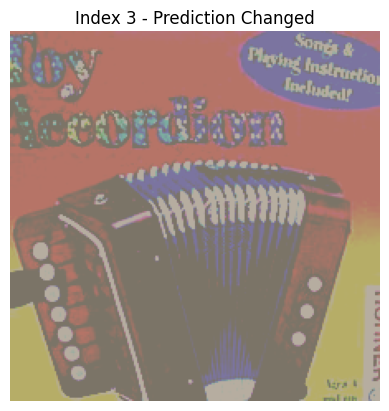

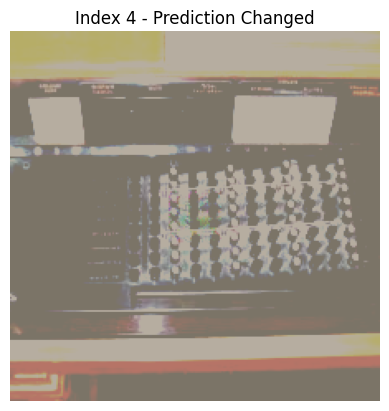


🧨 Patch Attack Top-1 Accuracy: 7.60%
🧨 Patch Attack Top-5 Accuracy: 26.40%


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import json
from PIL import Image
import random
import matplotlib.pyplot as plt

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.5  # higher allowed for patch attack
patch_size = 32

# Load model
resnet34 = torchvision.models.resnet34(weights='IMAGENET1K_V1')
resnet34.eval().to(device)

# Normalization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(device)

normalize = transforms.Normalize(mean.squeeze().tolist(), std.squeeze().tolist())
inv_normalize = transforms.Normalize(
    mean=(-mean / std).squeeze().tolist(),
    std=(1.0 / std).squeeze().tolist()
)

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# Load dataset
dataset_path = "./TestDataSet/TestDataSet"
with open(os.path.join(dataset_path, "labels_list.json"), "r") as f:
    label_lines = json.load(f)
true_imagenet_indices = [int(line.split(":")[0]) for line in label_lines]

imagefolder = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
folder_to_imagenet_index = {
    class_name: true_imagenet_indices[i]
    for i, class_name in enumerate(imagefolder.classes)
}
imagefolder.samples = [
    (path, folder_to_imagenet_index[os.path.basename(os.path.dirname(path))])
    for path, _ in imagefolder.samples
]

dataloader = DataLoader(imagefolder, batch_size=1, shuffle=False)

# Output dir
output_dir = "/content/drive/MyDrive/AdversarialTestSet3"
os.makedirs(output_dir, exist_ok=True)

# Patch attack
def patch_pgd_attack(image, label, epsilon=0.5, patch_size=32, alpha=0.15, steps=70):
    image = image.clone().detach().to(device)
    orig = image.clone().detach()
    _, _, H, W = image.shape

    # Try 5 fixed + random locations
    patch_positions = [
        (0, 0),  # top-left
        ((W - patch_size) // 2, (H - patch_size) // 2),  # center
        (W - patch_size, H - patch_size),  # bottom-right
        (random.randint(0, W - patch_size), random.randint(0, H - patch_size)),
        (random.randint(0, W - patch_size), random.randint(0, H - patch_size)),
    ]

    best_confidence = float("inf")
    best_adv_image = None

    for x, y in patch_positions:
        perturbed = image.clone().detach().requires_grad_(True)

        for _ in range(steps):
            output = resnet34(perturbed)
            loss = torch.nn.functional.cross_entropy(output, label)
            resnet34.zero_grad()
            loss.backward()

            grad = perturbed.grad.data
            patch = grad[:, :, y:y+patch_size, x:x+patch_size].sign()

            perturbed = perturbed.clone()
            perturbed[:, :, y:y+patch_size, x:x+patch_size] = (
                perturbed[:, :, y:y+patch_size, x:x+patch_size] + alpha * patch
            )

            perturbed = torch.max(torch.min(perturbed, orig + epsilon), orig - epsilon)
            perturbed = torch.clamp(perturbed, 0, 1).detach().requires_grad_(True)

        # Evaluate confidence in the correct label
        with torch.no_grad():
            final_output = resnet34(perturbed)
            true_logit = final_output[0, label.item()].item()

        if true_logit < best_confidence:
            best_confidence = true_logit
            best_adv_image = perturbed.detach()

    return best_adv_image

    # Try 3 strategic locations
    _, _, H, W = image.shape
    patch_locations = [
        (0, 0),  # top-left
        ((W - patch_size) // 2, (H - patch_size) // 2),  # center
        (W - patch_size, H - patch_size)  # bottom-right
    ]

    best_output_conf = float("inf")
    best_adv_image = None

    for x, y in patch_locations:
        adv = run_attack_with_patch(x, y)
        with torch.no_grad():
            out = resnet34(adv)
            conf = torch.nn.functional.cross_entropy(out, label)
            if conf < best_output_conf:
                best_output_conf = conf
                best_adv_image = adv

    return best_adv_image

# Generate and save
adv_images = []
true_labels = []
pred_changed = []

for idx, (img, label) in enumerate(tqdm(dataloader, desc="Patch Attack")):
    img, label = img.to(device), label.to(device)

    # Original prediction
    with torch.no_grad():
        orig_pred = resnet34(img).argmax(dim=1).item()

    # Patch adversarial image
    adv_img = patch_pgd_attack(img.clone(), label, epsilon=0.5, patch_size=32, alpha=0.1, steps=20)

    with torch.no_grad():
        adv_pred = resnet34(adv_img).argmax(dim=1).item()

    # Save
    adv_images.append(adv_img.squeeze().cpu())
    true_labels.append(label.item())
    pred_changed.append(orig_pred != adv_pred)

    out_path = os.path.join(output_dir, f"{idx:04d}.png")
    torchvision.utils.save_image(inv_normalize(adv_img.squeeze().cpu()).clamp(0, 1), out_path)

# Visualize 3–5 changed predictions
print("\n🎯 Patch Attack Visualizations:")
count = 0
for i in range(len(adv_images)):
    if pred_changed[i]:
        plt.imshow(inv_normalize(adv_images[i]).permute(1, 2, 0).clamp(0, 1))
        plt.title(f"Index {i} - Prediction Changed")
        plt.axis("off")
        plt.show()
        count += 1
    if count == 5:
        break

# Evaluation
class AdvDataset(torch.utils.data.Dataset):
    def __init__(self, image_tensors, labels):
        self.images = image_tensors
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

adv_dataset = AdvDataset(adv_images, true_labels)
adv_loader = DataLoader(adv_dataset, batch_size=32)

def evaluate(model, dataloader):
    top1_correct = 0
    top5_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, top1 = outputs.topk(1, dim=1)
            _, top5 = outputs.topk(5, dim=1)
            top1_correct += (top1.squeeze() == labels).sum().item()
            top5_correct += sum([labels[i] in top5[i] for i in range(labels.size(0))])
            total += labels.size(0)
    return 100 * top1_correct / total, 100 * top5_correct / total

top1_adv, top5_adv = evaluate(resnet34, adv_loader)
print(f"\n🧨 Patch Attack Top-1 Accuracy: {top1_adv:.2f}%")
print(f"🧨 Patch Attack Top-5 Accuracy: {top5_adv:.2f}%")


In [ ]:
import torch.nn.functional as F

def visualize_patch_attack(original_img, adv_img, label, model, idx=None):
    model.eval()
    original_img = original_img.detach().to(device)
    adv_img = adv_img.detach().to(device)
    label = label.detach().to(device)

    with torch.no_grad():
        output = model(adv_img.unsqueeze(0))
        probs = F.softmax(output, dim=1)
        top5_prob, top5_classes = torch.topk(probs, 5)
        top5_prob = top5_prob.squeeze().cpu().numpy()
        top5_classes = top5_classes.squeeze().cpu().numpy()

    noise = adv_img - original_img
    scaled_noise = (noise - noise.min()) / (noise.max() - noise.min() + 1e-8)

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    axs[0].imshow(inv_normalize(original_img.cpu()).permute(1, 2, 0).clamp(0, 1))
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(inv_normalize(adv_img.cpu()).permute(1, 2, 0).clamp(0, 1))
    axs[1].set_title("Adversarial")
    axs[1].axis("off")

    axs[2].imshow(scaled_noise.cpu().permute(1, 2, 0).clamp(0, 1))
    axs[2].set_title("Noise (scaled)")
    axs[2].axis("off")

    axs[3].barh([str(cls) for cls in top5_classes], top5_prob)
    axs[3].invert_yaxis()
    axs[3].set_xlim([0, 1])
    axs[3].set_title("Top-5 Predictions")
    axs[3].set_xlabel("Confidence")

    plt.tight_layout()
    if idx is not None:
        plt.savefig(f"patch_sample_{idx}.png", dpi=300)
    plt.show()

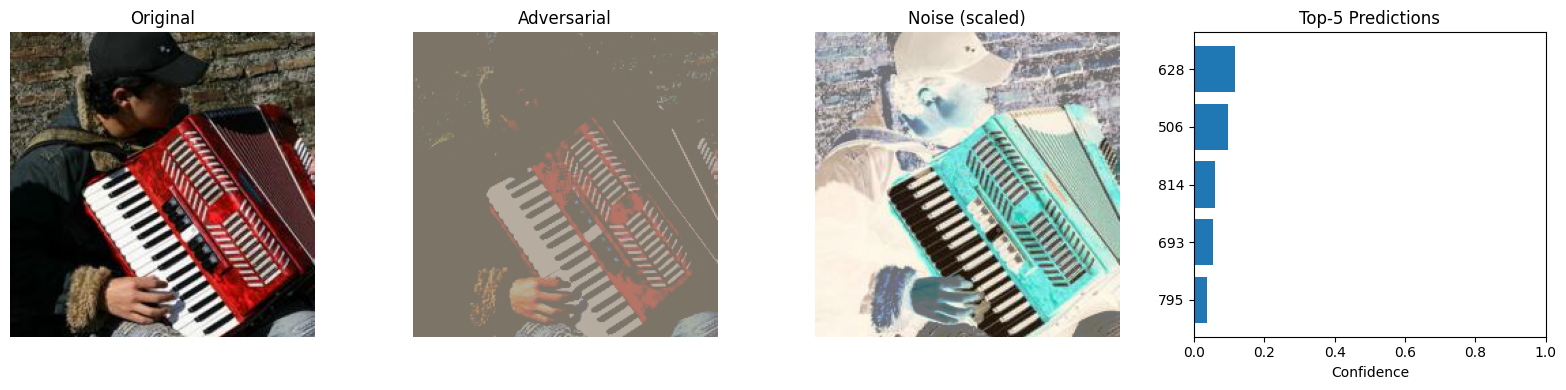

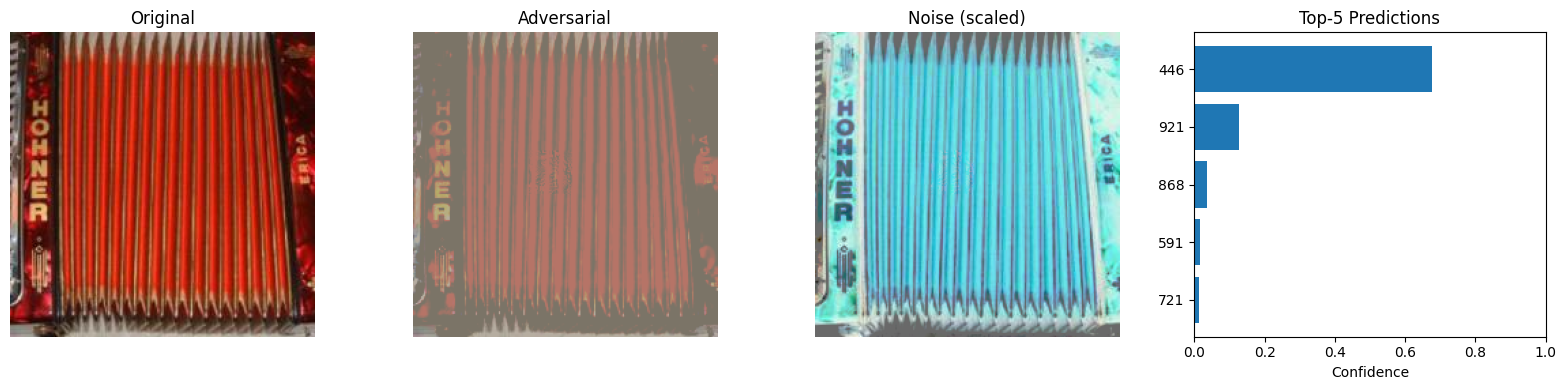

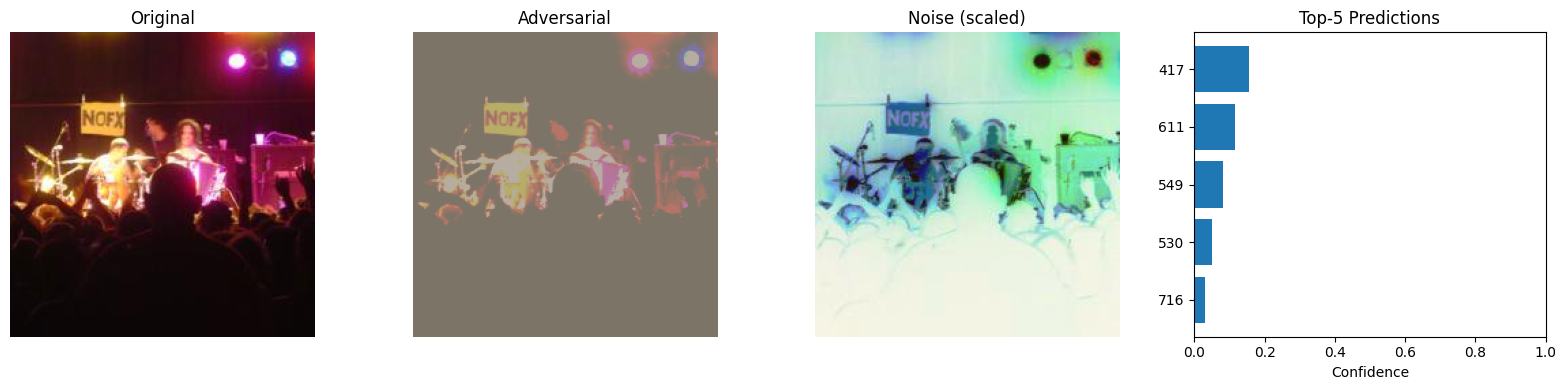

In [ ]:
for idx in range(3):  # or 5 for more
    img, lbl = imagefolder[idx]
    img = img.to(device)
    lbl_tensor = torch.tensor([lbl]).to(device)

    adv_img = patch_pgd_attack(img.unsqueeze(0), lbl_tensor, epsilon=0.5, patch_size=32, alpha=0.1, steps=20)
    visualize_patch_attack(img, adv_img.squeeze(0), lbl_tensor.squeeze(0), resnet34, idx=idx)

 ## TASK 5

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import os, json
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# —————————————————————————————————————————
# 1) Rebuild the original ImageFolder + true-label list
# —————————————————————————————————————————
dataset_path = "/content/drive/MyDrive/TestDataSet"
with open(os.path.join(dataset_path, "labels_list.json"), "r") as f:
    label_lines = json.load(f)
true_imagenet_indices = [int(line.split(":")[0]) for line in label_lines]

# load ImageFolder (no transform needed for labels)
orig_folder = torchvision.datasets.ImageFolder(root=dataset_path, transform=None)
# map each folder name to its true ImageNet index
folder_to_imagenet_index = {
    class_name: true_imagenet_indices[i]
    for i, class_name in enumerate(orig_folder.classes)
}
# overwrite samples so that each sample carries the correct ImageNet label
orig_folder.samples = [
    (path, folder_to_imagenet_index[os.path.basename(os.path.dirname(path))])
    for path, _ in orig_folder.samples
]
# sort samples by filename so ordering is deterministic
orig_folder.samples.sort(key=lambda x: x[0])
# extract the labels in that same order
orig_labels = [lbl for _, lbl in orig_folder.samples]

# —————————————————————————————————————————
# 2) New Dataset class for any adv-folder (FGSM, PGD, Patch)
# —————————————————————————————————————————
class AdvDataset(Dataset):
    def __init__(self, image_dir, true_labels, transform=None):
        self.image_paths = sorted(
            os.path.join(image_dir, fn)
            for fn in os.listdir(image_dir) if fn.endswith(".png")
        )
        assert len(self.image_paths) == len(true_labels), (
            f"Found {len(self.image_paths)} images but {len(true_labels)} labels"
        )
        self.labels = true_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# —————————————————————————————————————————
# 3) Evaluation code (e.g. on DenseNet-121)
# —————————————————————————————————————————
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
new_model.eval().to(device)

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

paths = {
    "Original": dataset_path,
    "FGSM":     "/content/drive/MyDrive/AdversarialTestSet1",
    "PGD":      "/content/drive/MyDrive/AdversarialTestSet2",
    "Patch":    "/content/drive/MyDrive/AdversarialTestSet3",
}

def evaluate(model, loader):
    top1 = top5 = total = 0
    with torch.no_grad():
        for imgs, lbls in tqdm(loader):
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            _, t1 = out.topk(1, dim=1)
            _, t5 = out.topk(5, dim=1)
            top1 += (t1.squeeze() == lbls).sum().item()
            top5 += sum([lbls[i] in t5[i] for i in range(len(lbls))])
            total += imgs.size(0)
    return 100*top1/total, 100*top5/total

results = {}
for name, p in paths.items():
    if name == "Original":
        ds = orig_folder  # already has transform=None; now attach transform
        ds.transform = transform
    else:
        ds = AdvDataset(p, orig_labels, transform)
    loader = DataLoader(ds, batch_size=32, shuffle=False)
    print(f"\n📊 Evaluating {name} dataset on DenseNet-121:")
    t1, t5 = evaluate(new_model, loader)
    results[name] = (t1, t5)
    print(f"→ Top-1: {t1:.2f}%   Top-5: {t5:.2f}%")

# Now `results` holds your table for Original, FGSM, PGD, Patch.


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 151MB/s]



📊 Evaluating Original dataset on DenseNet-121:


100%|██████████| 16/16 [00:03<00:00,  4.18it/s]


→ Top-1: 74.80%   Top-5: 93.60%

📊 Evaluating FGSM dataset on DenseNet-121:


100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


→ Top-1: 42.80%   Top-5: 66.40%

📊 Evaluating PGD dataset on DenseNet-121:


100%|██████████| 16/16 [00:05<00:00,  3.10it/s]


→ Top-1: 39.20%   Top-5: 65.00%

📊 Evaluating Patch dataset on DenseNet-121:


100%|██████████| 16/16 [00:05<00:00,  2.80it/s]

→ Top-1: 45.80%   Top-5: 67.60%


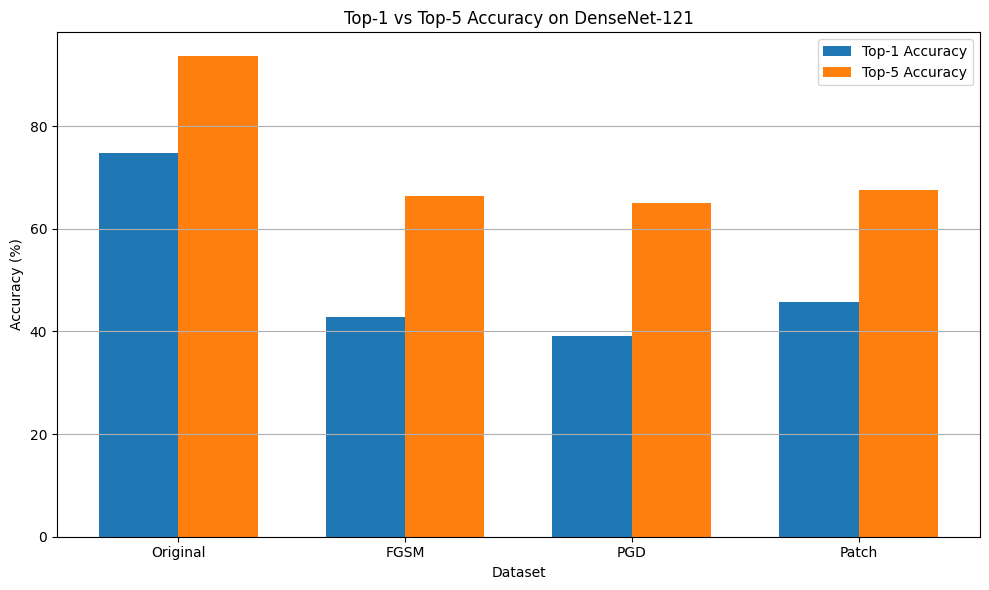

In [ ]:
import matplotlib.pyplot as plt

# Replace with your actual `results` dictionary if different
results = {
    "Original": (74.80, 93.60),
    "FGSM": (42.80, 66.40),
    "PGD": (39.20, 65.00),
    "Patch": (45.80, 67.60)
}

datasets = list(results.keys())
top1 = [results[k][0] for k in datasets]
top5 = [results[k][1] for k in datasets]

x = range(len(datasets))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([i - bar_width/2 for i in x], top1, width=bar_width, label="Top-1 Accuracy")
ax.bar([i + bar_width/2 for i in x], top5, width=bar_width, label="Top-5 Accuracy")

ax.set_xlabel("Dataset")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Top-1 vs Top-5 Accuracy on DenseNet-121")
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()